# Using Transformers to Understand Product Labelling

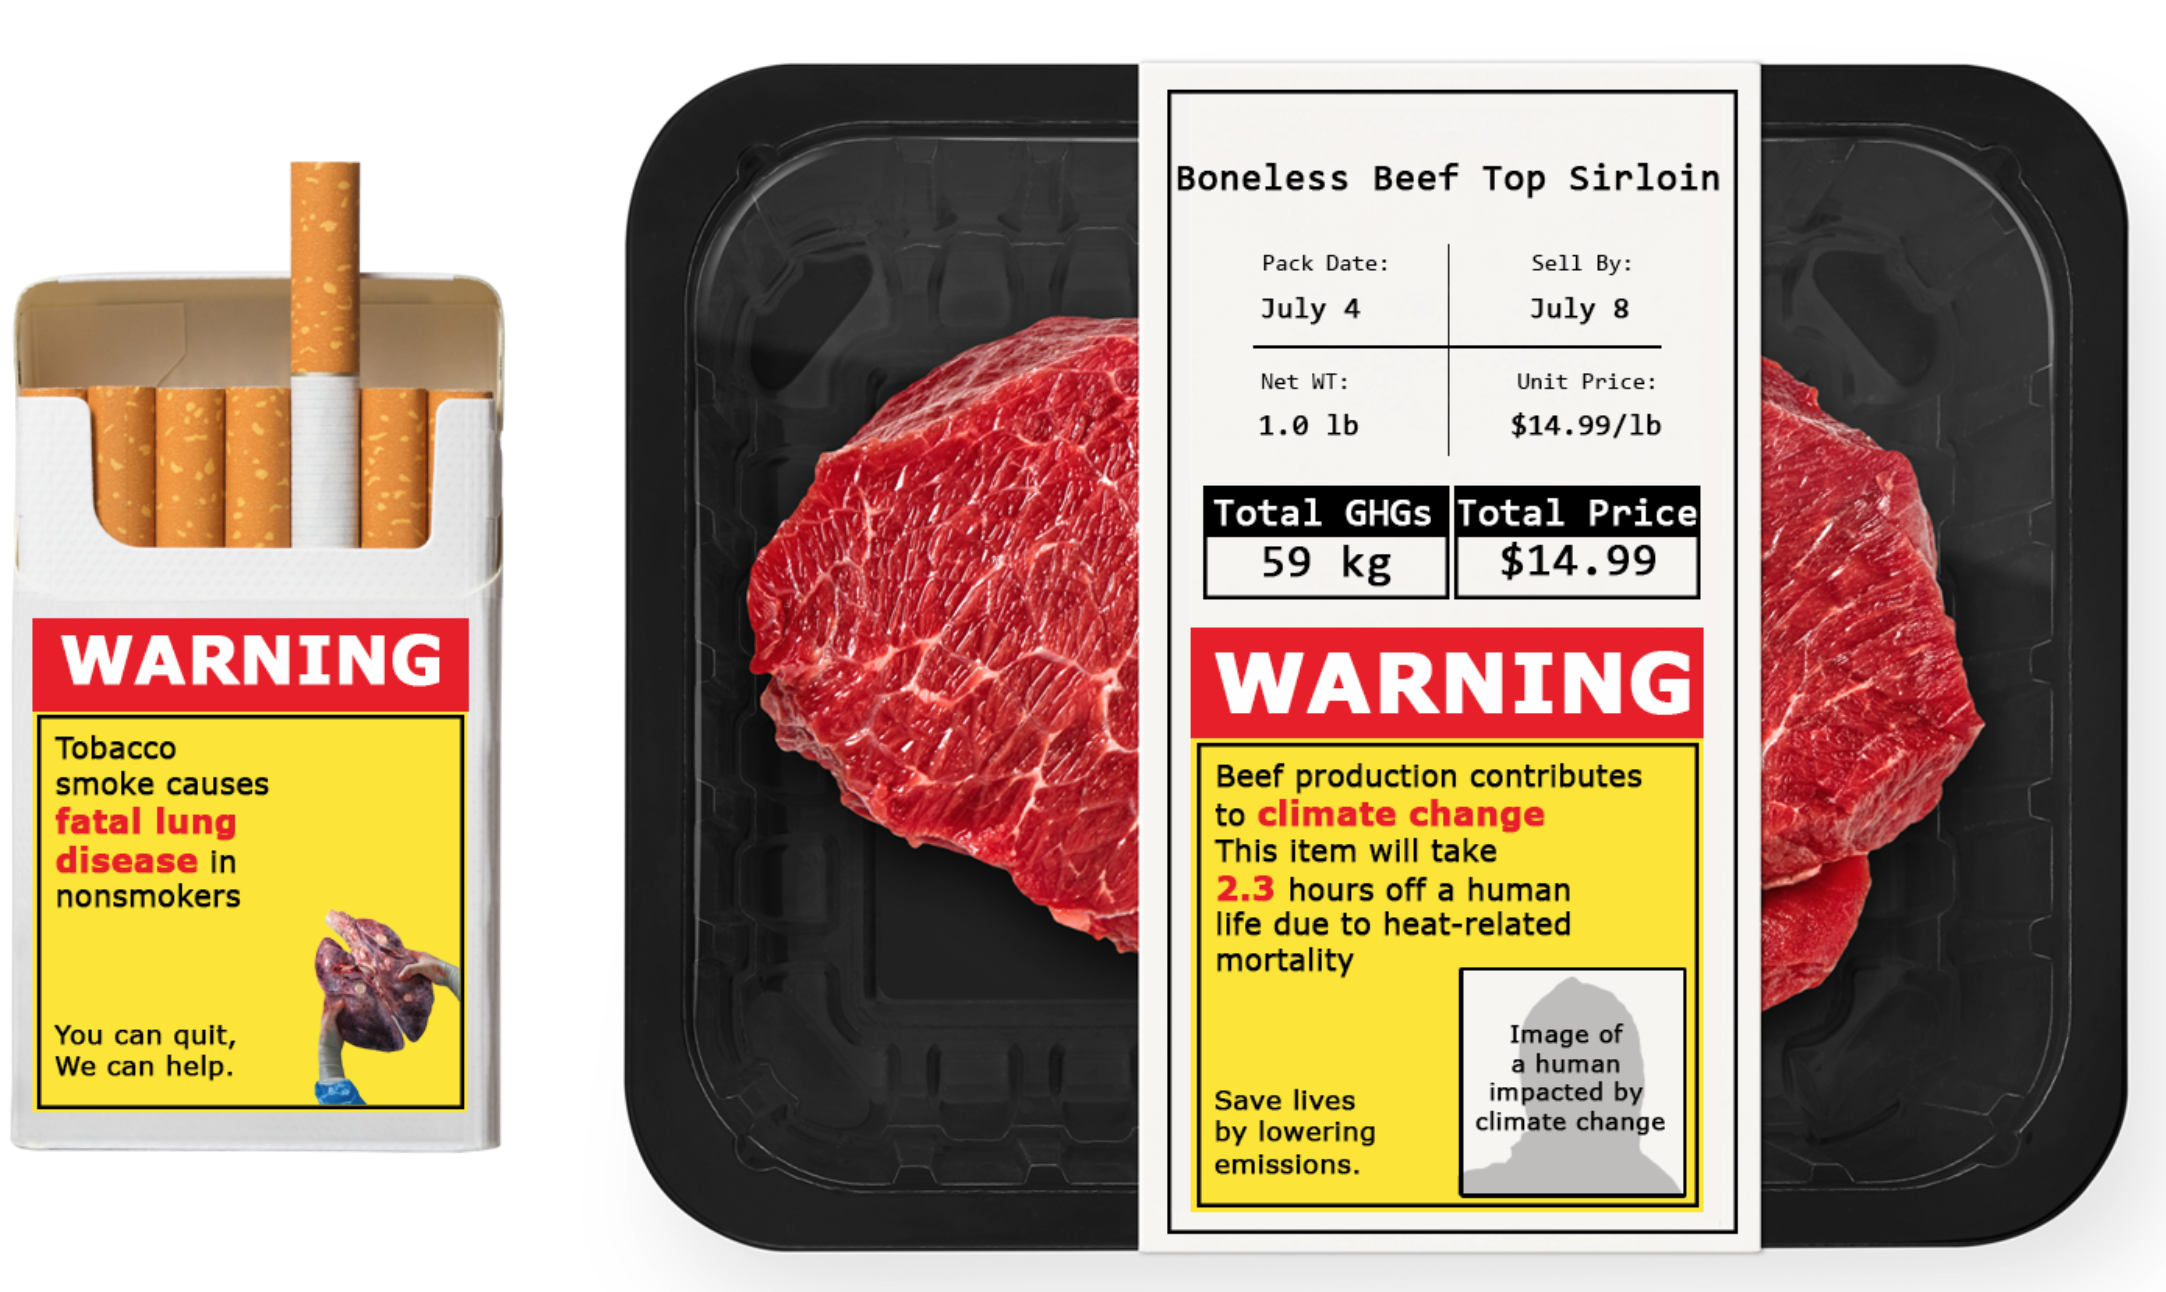
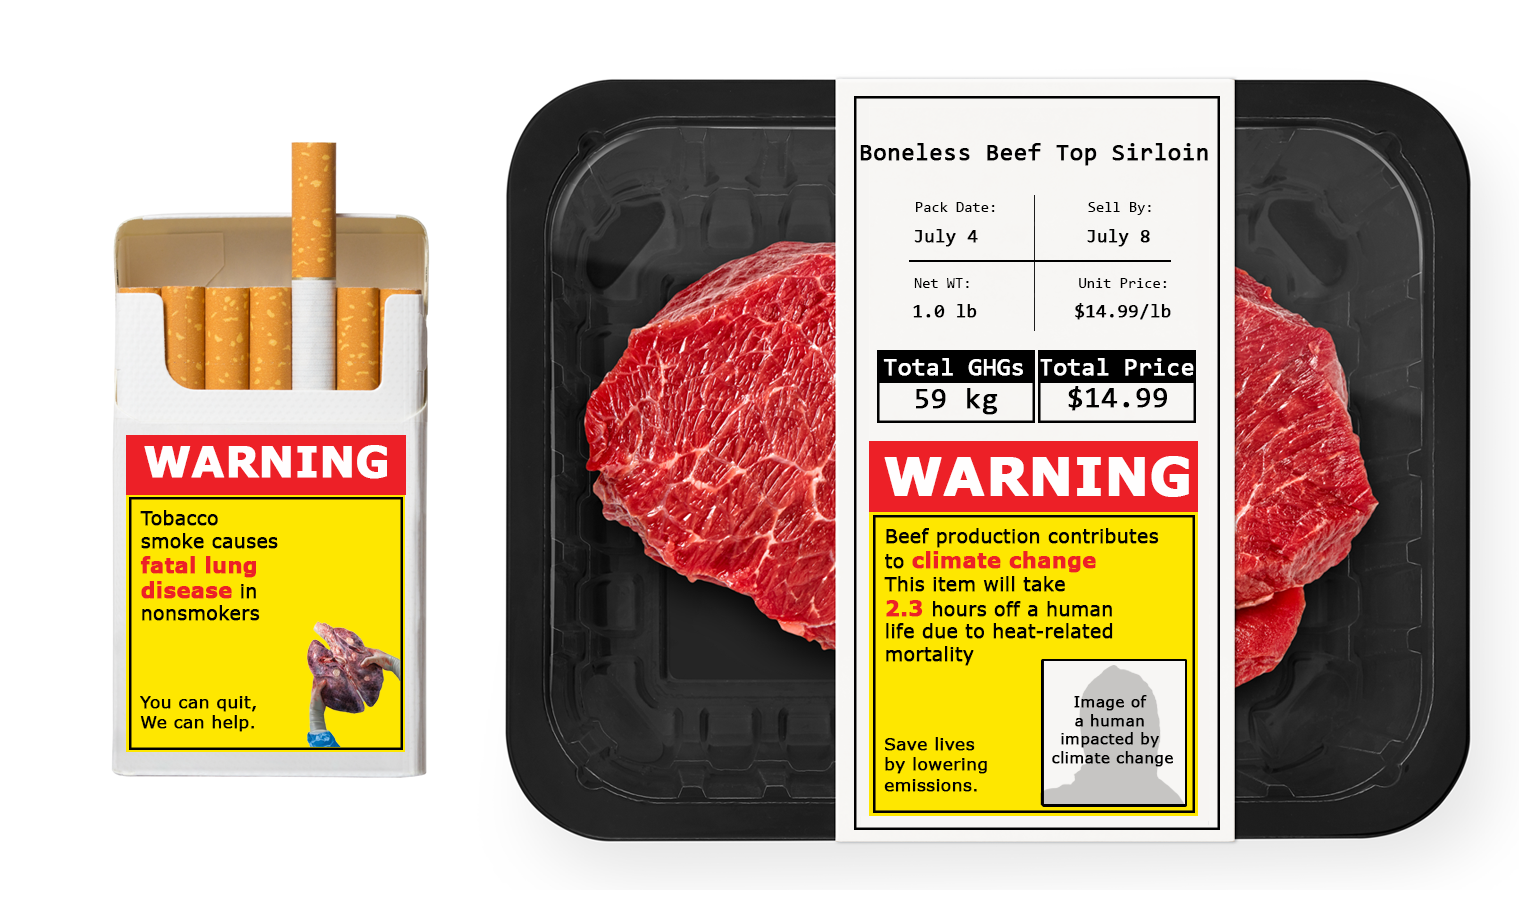

The consumption of many products and services carries carbon costs, and associated human health and mortality impacts due to climate change. In late 2024 we published an article proposing that accounting for these costs in labels could drive manufacturers towards net zero targets. You can read the paper here https://www.nature.com/articles/s41562-024-02087-0

This idea is controversial as you can imagine. You might wonder how people responded to this idea. While it is hard to assess directly from the paper,  earlier on in the year we did run an advocacy campaign which included a brief survey in which people had to pick some food items, travel options and from that were told how many minutes they would take from another persons life due to the climate change impacts of those consumption choices. https://ziamehrabi.medium.com/calculate-the-human-impact-of-your-everyday-decisions-6a65d63efec9. We  asked students in an Introductory Environmental Studies class what they thought too. 

The responses those students created were free form text based responses to a conversation. In this notebook you'll be leveraging pre-trained and off-the-shelf fine tuned language models to try and learn what those students thought and how this idea could potentially be improved.

## Environment Setup
We'll start by installing the `transformers` library from Hugging Face, the same one we used in Week 1. Since we’ll be using a lot of different features of the library, we'll install the development version, which comes with all the required dependencies for pretty much any imaginable use case


> Torch
> Transformers from hugging face ( pipelines )
> Download locally the bert-base-uncased model (~450MB)
> BERT https://huggingface.co/docs/transformers/en/model_doc/bert
> We might need another models for QA...


In [1]:
!pip install transformers[sentencepiece]

In [29]:
# read and manipulate data
import os
import pandas as pd
import seaborn as sns

# for running llms from hugging face
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

# ignore warnings because they're annoying
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [4]:
# checkpoint = "bert-base-uncased"
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

tokens = tokenizer(sequences, padding=True, truncation=True, return_tensors="pt")
output = model(**tokens)

In [5]:
output

SequenceClassifierOutput(loss=None, logits=tensor([[-1.5607,  1.6123],
        [-3.6183,  3.9137]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

## Pipelines() overview

The pipelines overview https://huggingface.co/docs/transformers/v4.49.0/en/main_classes/pipelines#transformers.pipeline (maybe we need to add this as a section or a graphic maybe of the key components? data, model, tokenization, prediction etc.). 

Easiest way to show this might be to show the code for a pipeline() and compare to say the more verbose transformers implementation.  That way you can show them what is being abstracted when you call pipeline(), and annotate the more verbose version.

In [6]:
classifier = pipeline(
    task="sentiment-analysis",
    model="distilbert/distilbert-base-uncased-finetuned-sst-2-english",
    device=0
)
preds = classifier("Hugging Face is the best thing since sliced bread!")
preds = [{"score": round(pred["score"], 4), "label": pred["label"]} for pred in preds]
preds

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


[{'score': 0.9991, 'label': 'POSITIVE'}]

## Read in the data 

The data is in a csv with a row for each student response. There is no index column, so just use the dataframe index as the student id. There may be some blank rows and some HTML artificats in the responses.

In [7]:
base_path = "/kaggle/input/student-product-labeling-responses/"
file_name = "student_responses.csv"
df = pd.read_csv(os.path.join(base_path, file_name))
df.head()

response
0  That quiz made me feel bad, I thought i was be...
1  I did not think that was possible. Im upset th...
2  This quiz was a great reality check and I feel...
3  I enjoyed this quiz, it showed how my decision...
4  I was incredibly shocked that with just a few ...

## Run sentiment analysis

Count the frequency of all the positive and negative responses to this idea. Overall what did people think? See here for quick overview of sentiment pipeline https://huggingface.co/docs/transformers/en/quicktour

In [30]:
classifier = pipeline(
    task="sentiment-analysis",
    model="distilbert/distilbert-base-uncased-finetuned-sst-2-english",
    device=0
)

inputs = df["response"].to_list()

preds = classifier(inputs)
preds = [{"score": round(pred["score"], 4), "label": pred["label"]} for pred in preds]
preds[0:10]

Device set to use cuda:0


[{'score': 0.6841, 'label': 'NEGATIVE'},
 {'score': 0.6371, 'label': 'NEGATIVE'},
 {'score': 0.996, 'label': 'POSITIVE'},
 {'score': 0.6822, 'label': 'NEGATIVE'},
 {'score': 0.9961, 'label': 'NEGATIVE'},
 {'score': 0.9979, 'label': 'POSITIVE'},
 {'score': 0.9158, 'label': 'NEGATIVE'},
 {'score': 0.9808, 'label': 'NEGATIVE'},
 {'score': 0.9884, 'label': 'POSITIVE'},
 {'score': 0.9932, 'label': 'POSITIVE'}]

In [12]:
preds_df = pd.DataFrame(preds)
preds_df.head()


score     label
0  0.6841  NEGATIVE
1  0.6371  NEGATIVE
2  0.9960  POSITIVE
3  0.6822  NEGATIVE
4  0.9961  NEGATIVE

<Axes: xlabel='score', ylabel='Count'>

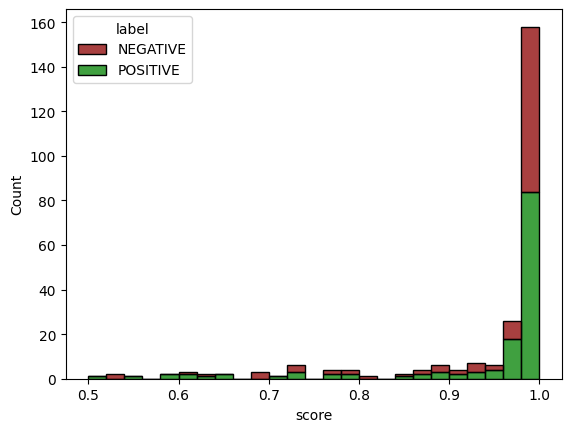

In [34]:
sns.histplot(
    data=preds_df, 
    x="score", 
    binwidth=0.02, 
    binrange=(0.5,1), 
    hue="label", 
    multiple="stack",
    palette=["darkred", "green"]
)

<Axes: xlabel='label', ylabel='Count'>

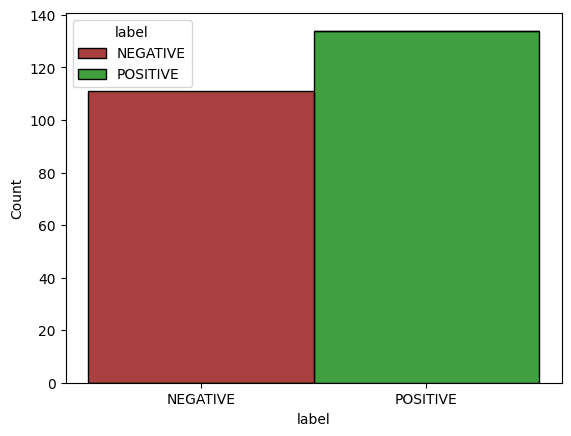

In [37]:
sns.histplot(
    data=preds_df, 
    x="label", 
    hue="label", 
    multiple="stack",
    palette=["darkred", "green"]
)

## Extract answers

During the conversation students were asked three questions in sequence, How did it make you feel? Was it an effective way to communicate this issue? What could be improved?. 

Use a QA pipeline to try extract the answer to "Was it an effective way to communicate this issue?"

> @Isaiah, would be surprised is bert base fine tuned on squad works here (i.e. as many short responses in that dataset, not all clauses), so would need to test if this works. Alternative models might work better, so we could explore a couple of others quickly. Would be nice to try this in an extractive way. 

> But if it fails could always rely on a generate model I supposed with enhanced reasoning, with prompt engineering (we can predefine the prompt for them)...



In [48]:
answerer = pipeline(
    task="question-answering",
    model="huggingface-course/bert-finetuned-squad",
    device=0
)

context = df["response"].to_list()[5]
print("The full answer is:", context)
question = "What did the student respond to whether or not this is an effective way to communicate this issue?"

resp = answerer(question=question, context=context)
resp

Device set to use cuda:0


The full answer is: I did not realize how my actions had deeply impacted the lives of others. I did feel like it was a good way to communicate the issue at hand. I can start trying to use public transportation more and add more plant-based meals to my diet. 


{'score': 0.13280826807022095,
 'start': 74,
 'end': 140,
 'answer': 'I did feel like it was a good way to communicate the issue at hand'}

## Re-analyse

Re-run the sentiment analysis on the effectivenes question. Count the frequencies of positive vs negative. Compare to the original sentiment analysis. How did it change your conclusions on the utility of this signalling strategy?


## How could we improve?
### initial exploration

Extract the text for the last question "how could this be improved". Retrieve embeddings for each response. Plot in 2D space (e.g. with PCA or similar). What does the distribution of responses look like? 

### return distinct responses.

Bin the data, e.g. across say PCA 1. Sample uniformly 10 examples across the distribution. Return the result. 

# Assignments

1. Repeat the last task for all questions in the conversation, collate into a summary of distinct ideas of what people thought for each.
2. Compare outputs of 1 to either an extractive (BERTSUM) or abstractive summarization model (like BART, T5) run over the whole dataset (first do summaries of the individual responses, then concatenate and do a summary of the result) Do the take-homes differ from your simple approach of sampling different responses? If so how? 
3. Generate your own sub queries/questions you want to ask these students, and return the 5 top individual responses that best match your queries using cosine similarity matches and rankings.
4. Did you get any truncation of the contexts using the tokenizer? How much were you missing? Update using chunking or additional model (Longformer), how did it change your results?
